In [98]:
filepath = "data/images/001.Black_footed_Albatross/Black_footed_Albatross_0008_1384283201.jpg"
matpath = "data/annotations/001.Black_footed_Albatross/Black_footed_Albatross_0008_1384283201.mat"

In [99]:
import scipy.io

In [100]:
import tensorflow as tf

In [101]:
mat_file = scipy.io.loadmat(matpath)

In [102]:
bbox = mat_file['bbox']

In [103]:
bbox

array([[(array([[70]], dtype=uint8), array([[63]], dtype=uint8), array([[499]], dtype=uint16), array([[398]], dtype=uint16))]],
      dtype=[('left', 'O'), ('top', 'O'), ('right', 'O'), ('bottom', 'O')])

In [104]:
left = bbox[0][0][0][0][0]
top = bbox[0][0][1][0][0]
right = bbox[0][0][2][0][0]
bottom = bbox[0][0][3][0][0]

In [105]:
import PIL

In [106]:
img = PIL.Image.open(filepath)

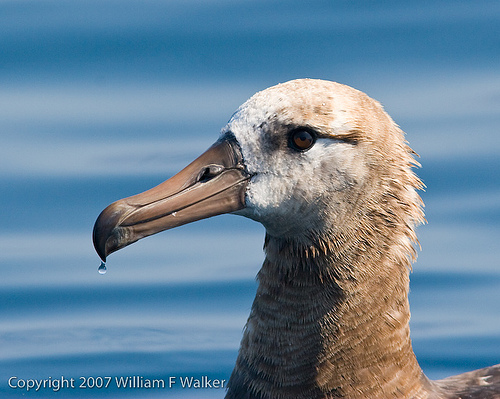

In [107]:
img

In [108]:
import PIL.ImageDraw

In [109]:
draw = PIL.ImageDraw.Draw(img)

In [110]:
draw.rectangle([left,top,right,bottom],outline="red", width=2)

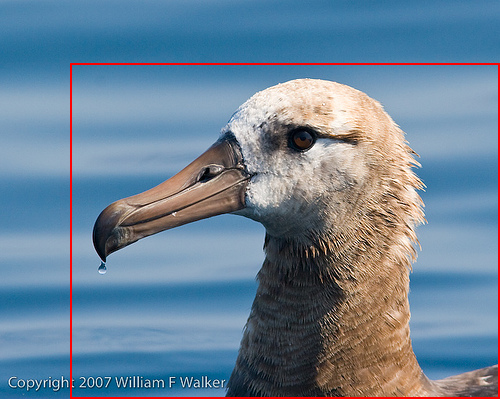

In [111]:
img

In [112]:
def get_bbox(filename):
    mat_file = scipy.io.loadmat(filename)
    bbox = mat_file['bbox'][0][0]
    left = bbox[0][0][0]
    top = bbox[1][0][0]
    right = bbox[2][0][0]
    bottom = bbox[3][0][0]
    return [left, top, right, bottom]

In [113]:
def draw_bbox(imagepath, bboxpath):
    bbox = get_bbox(bboxpath)
    img = PIL.Image.open(imagepath)
    draw = PIL.ImageDraw.Draw(img)
    draw.rectangle(bbox,outline="red", width=2)
    return img

In [114]:
img = draw_bbox(
    "data/images/003.Sooty_Albatross/Sooty_Albatross_0001_389284737.jpg",
    "data/annotations/003.Sooty_Albatross/Sooty_Albatross_0001_389284737.mat"
    )

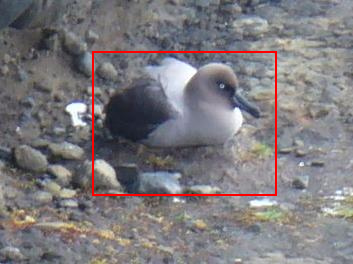

In [115]:
img

In [116]:
import os

In [117]:
def delete_file(base_path):
    path = os.listdir(base_path)
    for p in path:
        ppath = os.listdir(os.path.join(base_path,p))
        for pp in ppath:
            if pp.startswith("._"):
                os.remove(os.path.join(base_path,p,pp))

In [118]:
delete_file("data/images/")

In [119]:
# for _ , dir, filename in os.walk("data/images"):
#     print(dir)
#     for ffile in filename:
#         pass

In [120]:
def list_files(base_path):
    filepaths = []
    subdirs = os.listdir(base_path)
    for subdir in subdirs:
        subdir_path = os.path.join(base_path, subdir)
        files = os.listdir(subdir_path)
        for file_p in files:
            filepaths.append(os.path.join(base_path, subdir,file_p))
    return filepaths

In [121]:
images = list_files("data/images/")
bboxes = list_files("data/annotations/")

In [122]:
images[0]

'data/images/128.Seaside_Sparrow/Seaside_Sparrow_0019_2511462553.jpg'

In [123]:
bboxes[0]

'data/annotations/128.Seaside_Sparrow/Seaside_Sparrow_0007_2534637322.mat'

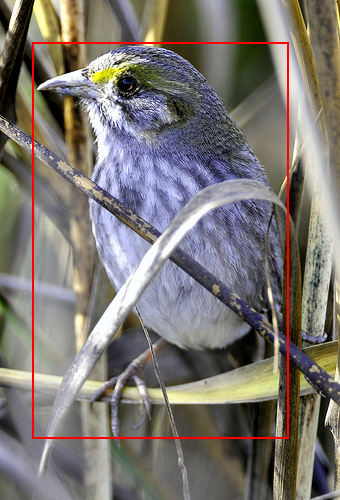

In [124]:
draw_bbox(images[3], bboxes[3])

In [125]:
# image_paths

### Preparing training data
Let's use generator to generate the training data since the data is big so keeping all the data in memory slows down the process

In [126]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [127]:
def prepare_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3, dtype=tf.float16)
    shape = img.numpy().shape
    img = tf.image.resize(img,[224,224])
    return img, shape   

In [128]:
def display_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [129]:
def resize_bbox(bbox, shape):
    height, width , _ = shape
    left, top, right, bottom = bbox
    left = left * (224/width)
    top = top * (224/height)
    right = right * (224/width)
    bottom = bottom * (224/height)
    return np.array([left, top, right, bottom])

In [130]:
def prepare_data(images, annotations):
    for idx in range(len(images)):
        image = images[idx]
        annotation = annotations[idx]
        image, shape = prepare_image(image)
        bbox = get_bbox(annotation)
        bbox = resize_bbox(bbox, shape)
        yield image, bbox

In [131]:
from sklearn.model_selection import train_test_split

In [132]:
train_images, val_images, train_annos, val_annos = train_test_split(images, bboxes, test_size=0.15, random_state=42)

In [133]:
train_images, test_images, train_annos, test_annos = train_test_split(train_images, train_annos, test_size=0.10, random_state=42)

In [134]:
len(test_annos)

513

In [135]:
train_dataset = tf.data.Dataset.from_generator(
                prepare_data,
                args=[train_images, train_annos],
                output_types=(tf.float16, tf.float16),
                output_shapes=(
                    (224,224,3),
                    (4,)
                )
            )   

In [136]:
val_dataset = tf.data.Dataset.from_generator(
                prepare_data,
                args=[val_images, val_annos],
                output_types=(tf.float16, tf.float16),
                output_shapes=(
                    (224,224,3),
                    (4,)
                )
            )  

In [137]:
test_dataset = tf.data.Dataset.from_generator(
                prepare_data,
                args=[test_images, test_annos],
                output_types=(tf.float16, tf.float16),
                output_shapes=(
                    (224,224,3),
                    (4,)
                )
            )  

In [138]:
BATCH_SIZE = 20
LEARNING_RATE = 0.001
EPOCHS = 20

In [139]:
train_dataset = train_dataset.shuffle(512).repeat().batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(200).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(100).batch(1).prefetch(tf.data.AUTOTUNE)

## Build Model
Let's build a model for object localization. We can make use of pretrained models for easiness.

In [140]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [141]:
mobile_net_model = MobileNetV2(include_top=False,
                  input_shape=(224,224,3))

In [142]:
mobile_net_model.summary()

_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 14, 14, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 14, 14, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 14, 14, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][0]   

In [143]:
model = tf.keras.models.Sequential()
model.add(mobile_net_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(4))

In [144]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              64226304  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)              

In [145]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=['accuracy'])

In [146]:
def callbacks():
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", monitor='val_accuracy',mode='max',save_best_only=True)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3,mode='max', restore_best_weights=True)
    return [model_checkpoint,early_stopping]

In [97]:
model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(train_images)//BATCH_SIZE, validation_data=val_dataset, validation_steps=len(val_images)//BATCH_SIZE, callbacks=callbacks())

Epoch 1/20
307/307 [==============================] - 129s 396ms/step - loss: nan - accuracy: 0.0033 - val_loss: nan - val_accuracy: 0.0000e+00
/anaconda/envs/py38_tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
Epoch 2/20
 55/307 [====>.........................] - ETA: 1:31 - loss: nan - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [112]:
def draw_bbox(imagepath, bbox):
    img = PIL.Image.open(imagepath)
    img = img.resize((224,224))
    draw = PIL.ImageDraw.Draw(img)
    draw.rectangle(bbox,outline="red", width=2)
    return img

In [113]:
def predict_and_draw(model,image_path):
    image, shape = prepare_image(image_path)
    image = image[np.newaxis,...]
    bbox = model.predict(image)
    img = draw_bbox(image_path, bbox)
    return img

In [114]:
def iou(original, predicted):
    x1, y1, x2, y2 = original
    x3, y3, x4, y4 = predicted
    x_inter_1 = max(x1, x3)
    y_inter_1 = max(y1, y3)
    x_inter_2 = min(x2, x4)
    y_inter_2 = min(y2, y4)

    inter_width = max(x_inter_2 - x_inter_1, 0)
    inter_height = max(y_inter_2 - y_inter_1, 0)
    inter_area = inter_height * inter_width

    box1_width = abs(x2-x1)
    box1_height = abs(y2-y1)
    box2_width = abs(x4-x3)
    box2_height = abs(y4-y3)
    box1_area = box1_height * box1_width
    box2_area = box2_height * box2_width

    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

In [126]:
def draw_original_and_predicted_box(image_path, box1, box2):
    img = PIL.Image.open(imagepath)
    img = img.resize((224,224))
    draw = PIL.ImageDraw.Draw(img)
    draw.rectangle(box1,outline="red", width=2)
    draw.rectangle(box2,outline="blue", width=2)
    return img

In [125]:
def calculate_ious(model, dataset):
    ious = []
    for t_data in test_dataset.take(len(test_images)):
        original_bbox = t_data[1].numpy().tolist()
        predicted_bbox = model.predict(t_data[0])
        ious.append(original_bbox, predicted_bbox.numpy())
    ious = np.array(ious)
    max_iou = np.max(ious)
    min_iou = np.min(ious)
    avg_iou = np.mean(ious)
    return max_iou, avg_iou, min_iou

In [137]:
def predict_and_draw_both(model, image_path):
    filepath = os.path.splitext(image_path)[0].split("/")
    folder = filepath[2]
    filename = filepath[3]
    bbox_path = os.path.join("data/annotations/",folder,filename+".mat")
    image, shape = prepare_image(image_path)
    image = image[np.newaxis,...]
    original_bbox = get_bbox(bbox_path)
    original_bbox = resize_bbox(original_bbox,shape)
    predicted_bbox = model.predict(image)
    img = draw_original_and_predicted_box(image_path, original_bbox,  predicted_bbox.numpy())
    return img

In [ ]:
calculate_ious(model,test_dataset)

In [ ]:
model.save("model.h5")

In [ ]:
predict_and_draw(model,"data/images/006.Least_Auklet/Least_Auklet_0001_2947317867.jpg")

In [ ]:
predict_and_draw_both(model, "data/images/006.Least_Auklet/Least_Auklet_0001_2947317867.jpg")